In [1]:
import experts

from experts import problems
from experts.problems import ScalarExpertsProblem

import numpy as np
import pandas as pd
import seaborn as sns

import random

# Random outcomes

Consider a sequence of length T = 100.

In [2]:
random.seed(42)

T = 100

y = np.floor(2*np.random.rand(T))

print(y)

[0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0.]


An expert makes a prediction for each time step
and can also be represented by a vector of predictions
at each time step.

So to create n = 10 experts,
each making predictions for a vector of length 100,
we simply create a matrix with 100 rows and n = 10 columns.
One column per expert, one row per time step.

In [3]:
n = 10

E1 = np.random.rand(T, n)

To run the mixture of experts algorithm we first
initialise a ScalarExpertsProblem
with the experts' prediction matrix
and outcome vector.

In [4]:
A = ScalarExpertsProblem(E1, y)

Now we can call the mixture method,
passing a choice of learning rate,
if we choose.

In [5]:
beta = 0.01

result = A.mixture(beta)

## Expert losses

To evaluate the predictions of the experts we can look at the expert-loss
matrix.

In [6]:
expert_losses = np.sum(result["expert-loss"], axis = 0)
print(expert_losses)

[53.75262902 42.82275973 49.213615   51.33568201 51.69102803 47.76587152
 46.74995243 45.81081493 48.17259182 48.13108743]


In this case we can see that the best expert is the expert with the lowest error.

In [7]:
best_expert_index = np.argmin(expert_losses)
print(best_expert_index)

1


And the loss made by that best expert is loss corresponding to that index or, equivalently, the minimum value of the expert_losses vector.

In [8]:
best_expert_total_loss = np.min(expert_losses)
print(best_expert_total_loss)

42.82275972712779


Compare that to the learner's total loss, which is only slightly more.

In [10]:
learner_total_loss = np.sum(result["learner-loss"], axis = 0)
print(learner_total_loss)

43.936856945109966


In fact, the learner only accumulated less than 3% more loss over the one hundred time steps.

In [12]:
abs(best_expert_total_loss - learner_total_loss)/best_expert_total_loss

0.026016474068494187

## Plots

First, lettuce plot the loss of the best expert and the learner against time.

In [13]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        learner = result["learner-loss"],
        best_expert = result["expert-loss"][:, best_expert_index]
        )
    )

df_long = pd.melt(df, ['time'])

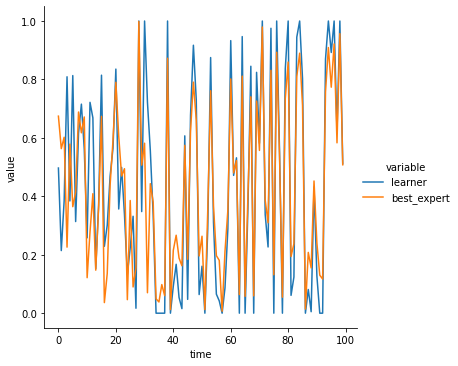

In [14]:
sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

It seems clear that the learner has learned to follow the predictions of the best expert. In fact, the learner starts tracking the best expert at an early stage.

Now lettuce look at the cumulative loss over time. We would expect to see that the total loss of the learner tracks the loss of the best expert eventually. Early on we might see that the learner does much worse.

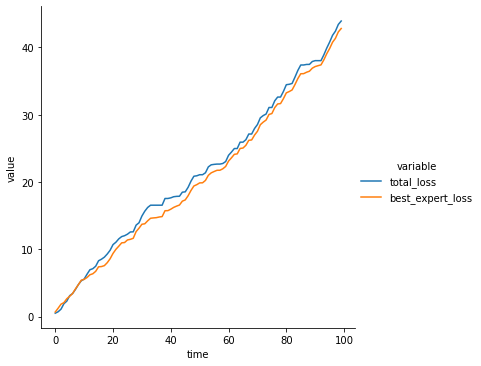

In [16]:
df_cum = pd.DataFrame(
    dict(
        time = np.arange(100),
        total_loss = result["learner-loss"].cumsum(),
        best_expert_loss = result["expert-loss"][:, best_expert_index].cumsum()
        )
    )

df_cum_long = pd.melt(df_cum, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_cum_long)

In this experiment we saw that the learner tracks the best expert and accumulates only slightly more loss over the timespan of the experiment. However, the best expert here isn't really successful at making predictions either so even if the learner was simply making random predictions we would probably see the same behaviour. So what happens when there is an expert among our ten experts that makes good predictions? In the next section we contrive an experiment to test this.

# Outcomes as experts

An easy way to create an expert that makes good predictions is simply to copy the outcome sequence and add that to the pool of experts.

In [21]:
E2 = E1.copy()
E2[:, n - 1] = y

Of course, this best expert won't incur any loss because it's predictions are identical to the outcome sequence for the full timespan. So we can add a bit of noise to make it seem like this is an expert that has a pretty good idea about the outcome sequence but doesn't get it exactly right.

In [22]:
for t in range(T):
  a = random.gauss(0, 0.01)
  if 0 <= a + E2[t, n - 1] <= 1:
    E2[t, n - 1] = a + E2[t, n - 1]

Run the mixture algorithm with the same outcomes but with this new pool of experts that includes the noisy copy of the outcome.

In [23]:
A = ScalarExpertsProblem(E2, y)
result = A.mixture(beta)

Recalculate the index of the best expert.

In [24]:
expert_losses = np.sum(result["expert-loss"], axis = 0)
best_expert_total_loss = np.min(expert_losses)
best_expert_index = np.argmin(expert_losses)

Plot the learner loss and best expert loss against time.

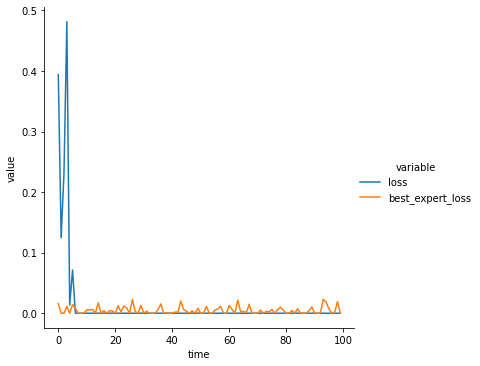

In [29]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        loss = result["learner-loss"],
        best_expert_loss = result["expert-loss"][:, best_expert_index]
    )
)

df_long = pd.melt(df, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

Here you can see that the best expert only incurs loss due to noise and the learner quickly picks up on the skill of this particular forecaster and makes apparently better predictions (because only 0/1 output?). Notice that early on the learner was beginning to make some much greater losses before it had honed in on the best expert.

Finally, lettuce plot the cumulative loss of both the best expert and the learner.

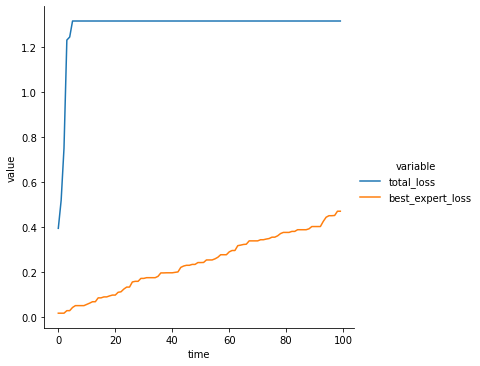

In [30]:
df_cum = pd.DataFrame(
    dict(
        time = np.arange(100),
        total_loss = result["learner-loss"].cumsum(),
        best_expert_loss = result["expert-loss"][:, best_expert_index].cumsum()
        )
    )

df_cum_long = pd.melt(df_cum, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_cum_long)

Here we can see that the learner quickly accumulates significantly greater losses than the best expert but once it starts tracking the best expert it makes no further loss.